In [4]:
#Configurando TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [3]:
#Configurando GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found')
else:
    print('Default GPU device: {}' .format(tf.test.gpu_device_name()))
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Default GPU device: /device:GPU:0


In [1]:
#Importações
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model, Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications.resnet_v2 import ResNet50V2
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from statistics import mean, stdev
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import random
import os
import numpy as np

In [2]:
#Variaveis de controle
class_names = ['Pituitary', 'NoTumor', 'Meningioma', 'Glioma']
epochs = 100
batch_size = 32
img_size = 240
path_train = 'drive/MyDrive/BrainTumor/dataset/Training'
path_test = 'drive/MyDrive/BrainTumor/dataset/Testing'

In [3]:
#Configurando gerador de imagens
def CarregaDados():

  img_generator = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.08,
        horizontal_flip=True
  )

  img_generator_train = img_generator.flow_from_directory(path_train, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical', shuffle=True)
  img_generator_test = img_generator.flow_from_directory(path_test, target_size=(img_size, img_size), batch_size=1, class_mode='categorical', shuffle=True)

  return img_generator_train, img_generator_test

In [4]:
#Criando estrutura de rede neural tendo ResNet50V2 como base
def CriaRede():
  base_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_size, img_size, 3),
  )

  model = Sequential([
    base_model,
    Dropout(0.3),
    GlobalAveragePooling2D(),
    Dropout(0.25),
    Dense(128, activation= 'relu'),
    Dropout(0.25),
    Dense(4, activation= 'softmax')
  ])

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [5]:
#Treinando modelo
def Treinamento():
  train, test = CarregaDados()

  es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, min_delta=1e-10)
  rlp = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1)
  md = ModelCheckpoint(monitor='val_accuracy' ,filepath='drive/MyDrive/BrainTumor/ResNet50.h5', verbose=1, save_best_only=True)

  try:
    model = load_model('drive/MyDrive/BrainTumor/ResNet50.h5')
  except:
    model = CriaRede()

  STEP_SIZE_TRAIN=train.n//train.batch_size
  STEP_SIZE_VALID=test.n//test.batch_size

  result = model.fit_generator(generator=train, steps_per_epoch=STEP_SIZE_TRAIN, epochs=epochs, callbacks=[es, rlp, md], validation_data=test, validation_steps=STEP_SIZE_VALID)

  media = mean(result.history['val_accuracy'])
  desvio = stdev(result['val_accuracy'])

  plt.plot(result.history['val_loss'])
  plt.tittle('Gradiente')
  plt.xlabel('Épocas')
  plt.ylabel('Perda')
  plt.show()

  plt.plot(result.history('val_accuracy'))
  plt.tittle('Acurácia\n'+'Média:'+str(media)+'\nDesvio Padrão:'+str(desvio))
  plt.xlabel('Épocas')
  plt.ylabel('Acurácia')
  plt.show()

In [6]:
#Visualizando resultados
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)

    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label], 100*np.max(predictions_array), class_names[true_label]), color=color, fontsize=6)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color='#777777')
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

def Previsao():
  _, test = CarregaDados()

  test_images = np.empty([0,240,240,3])
  test_labels = np.empty([0,4])
  i = 0
  for img, label in tqdm(test):
    if i == 1311:
      break
    test_images = np.append(test_images, img, axis=0)
    test_labels = np.append(test_labels, label, axis=0)
    i = i+1

  model = load_model('drive/MyDrive/BrainTumor/ResNet50.h5')
  predictions = model.predict(test_images)

  num_rows = 7
  num_cols = 7
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    r = random.randrange(1,len(test_labels))
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(r, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(r, predictions, test_labels)
  plt.show()

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


100%|██████████| 1311/1311 [12:15<00:00,  1.78it/s]


41/41 [==============================] - 232s 6s/step


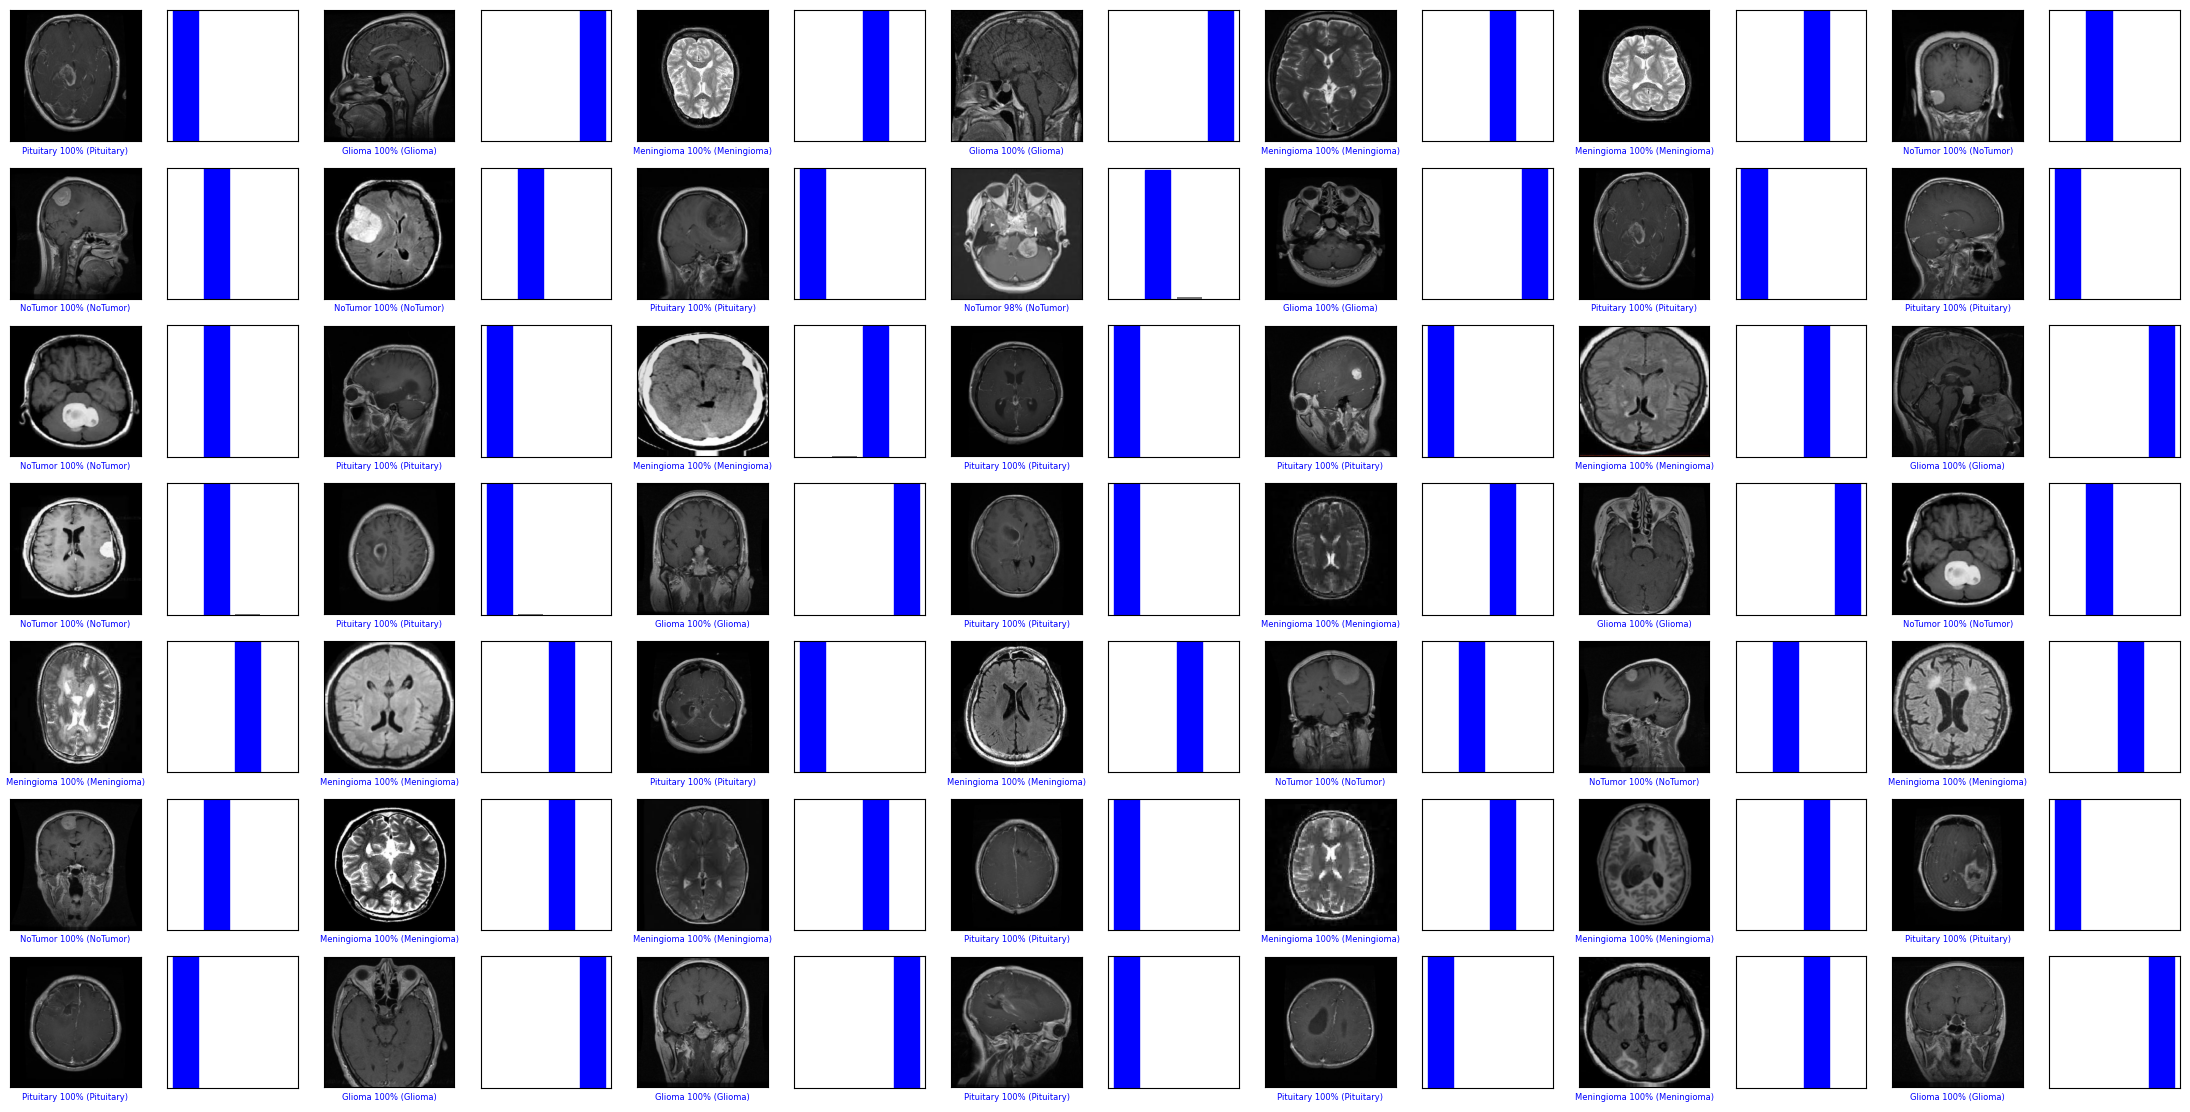

In [7]:
#with tf.device('/GPU:0'):
#  Treinamento()
Previsao()